# Analyzing Supply Chain Dynamics: A Regression Approach to Transportation Rate Optimization

### Intro

In this project, we will explore a supply-chain dataset sourced from the USAID website, specifically the USAID GHSC PSM Health Commodity Delivery Dataset. Our primary objective is to investigate whether various features within the dataset influence the rate price for transporting goods. This will be approached as a regression problem, allowing us to apply different machine learning models, including the Random Forest Regressor, Decision Tree Regressor, and Linear Regression.

To ensure a thorough understanding of the dataset and uncover underlying patterns, we will conduct Exploratory Data Analysis (EDA). This will involve visualizing the data, analyzing distributions, and identifying any correlations between features and the target variable. Depending on the insights gained from EDA, we may perform feature engineering to enhance the dataset, ensuring our models can effectively learn from the available data.

Through this project, we aim to derive actionable insights that could improve decision-making in supply chain management and optimize transportation costs for health commodities.

In [107]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve, ShuffleSplit, train_test_split, GridSearchCV, cross_val_score
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
import joblib

In [2]:
data = pd.read_excel("Supply chain logisitcs problem.xlsx", sheet_name="FreightRates")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Carrier       1540 non-null   object 
 1   orig_port_cd  1540 non-null   object 
 2   dest_port_cd  1540 non-null   object 
 3   minm_wgh_qty  1540 non-null   float64
 4   max_wgh_qty   1540 non-null   float64
 5   svc_cd        1540 non-null   object 
 6   minimum cost  1540 non-null   float64
 7   rate          1540 non-null   float64
 8   mode_dsc      1540 non-null   object 
 9   tpt_day_cnt   1540 non-null   int64  
 10  Carrier type  1540 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 132.5+ KB


In [4]:
data.head()

,Carrier,orig_port_cd,dest_port_cd,minm_wgh_qty,max_wgh_qty,svc_cd,minimum cost,rate,mode_dsc,tpt_day_cnt,Carrier type
0,V444_6,PORT08,PORT09,250.0,499.99,DTD,43.2272,0.7132,AIR,2,V88888888_0
1,V444_6,PORT08,PORT09,65.0,69.99,DTD,43.2272,0.7512,AIR,2,V88888888_0
2,V444_6,PORT08,PORT09,60.0,64.99,DTD,43.2272,0.7892,AIR,2,V88888888_0
3,V444_6,PORT08,PORT09,50.0,54.99,DTD,43.2272,0.8272,AIR,2,V88888888_0
4,V444_6,PORT08,PORT09,35.0,39.99,DTD,43.2272,1.0552,AIR,2,V88888888_0


In [5]:
data = data.rename(
    columns={
    "Carrier": "carrier",
    'orig_port_cd': "origin_port_code",
    'dest_port_cd': "destination_port_code",
    'minm_wgh_qty': "min_weight_quantity",
    'max_wgh_qty': "max_weight_quantity", 
    'svc_cd': "service_code",
    'minimum cost': "minimum_cost", 
    'mode_dsc': "mode_description",
    'tpt_day_cnt': "transport_day_count", 
    'Carrier type': "carrier_type"
    }
)

In [6]:
data.columns

Index(['carrier', 'origin_port_code', 'destination_port_code',
       'min_weight_quantity', 'max_weight_quantity', 'service_code',
       'minimum_cost', 'rate', 'mode_description', 'transport_day_count',
       'carrier_type'],
      dtype='object')

Renamed columns to make them more understandable.

## Column Meaning

1.**carrier**: Represents the shipping or transport carrier company. Each carrier might be associated with specific services, transport modes, and costs.
	
2.**origin_port_code**: Stands for origin port code. This column represents the code or identifier for the location (port) from which the shipment originates.

3.**destination_port_code**: Stands for destination port code. This column represents the code or identifier for the location (port) where the shipment is delivered.

4.**minimun_weight_quantity**: Short for minimum weight quantity. This represents the minimum weight (in a specific unit) for which the rate or cost applies.

5.**max_weight_quantity** Short for maximum weight quantity. This represents the maximum weight (in a specific unit) for which the rate or cost applies.

6.**service_code**: Stands for service code. This represents the type or level of service offered by the carrier (e.g., dtp: door-to-port, dtd: door-to-door, etc.).

7.**minimum_cost** : Represents the minimum cost charged for the shipment within the specified weight range, regardless of the exact weight.

8.**rate**: Represents the cost rate (likely per unit of weight) that is charged by the carrier for the shipment. This value is applied based on the minm_wgh_qty and max_wgh_qty.

9.**mode_description**: Short for mode description. This represents the transportation mode used by the carrier (e.g., AIR, GROUND).

10.**transport_day_count**: Short for transport day count. This column represents the number of days it will take for the shipment to be transported from the origin port to the destination port.
	
11.**carrier_type**: Represents the type or classification of the carrier (e.g., based on the nature of the service, company type, or other differentiators). It could be a code or description for internal categorization.

## Checking for Duplicates or Missing Values

### Missing Values: 

In [7]:
data.isna().sum()

carrier                  0
origin_port_code         0
destination_port_code    0
min_weight_quantity      0
max_weight_quantity      0
service_code             0
minimum_cost             0
rate                     0
mode_description         0
transport_day_count      0
carrier_type             0
dtype: int64

### Duplicate rows

In [8]:
print(data.duplicated().sum())

3


In [9]:
data[data.duplicated()]

,carrier,origin_port_code,destination_port_code,min_weight_quantity,max_weight_quantity,service_code,minimum_cost,rate,mode_description,transport_day_count,carrier_type
1494,V444_5,PORT03,PORT09,0.0,5000.0,DTD,27.2024,9.2024,GROUND,1,V88888888_0
1505,V444_0,PORT03,PORT09,0.0,5000.0,DTD,27.2024,13.2024,GROUND,1,V88888888_0
1510,V444_0,PORT03,PORT09,0.0,5000.0,DTD,27.2024,13.2024,GROUND,1,V88888888_0


In [10]:
data = data.drop(index=1505)
data.reset_index(inplace=True, drop=True)

After analyzing the duplicates, we found three rows. The first row differs from the others due to a different value in the rate column. Therefore, we will drop either the second or the third row, as they are identical in all other columns.

## Feature Engineering

In [11]:
label_encoder = LabelEncoder()

In [12]:
categorical_columns = [
    'carrier',
    'origin_port_code',
    'destination_port_code',
    'mode_description',
    'service_code',
    'carrier_type'
]

for column in categorical_columns:
    label_encoder = LabelEncoder()
    data[column] = label_encoder.fit_transform(data[column])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   carrier                1539 non-null   int64  
 1   origin_port_code       1539 non-null   int64  
 2   destination_port_code  1539 non-null   int64  
 3   min_weight_quantity    1539 non-null   float64
 4   max_weight_quantity    1539 non-null   float64
 5   service_code           1539 non-null   int64  
 6   minimum_cost           1539 non-null   float64
 7   rate                   1539 non-null   float64
 8   mode_description       1539 non-null   int64  
 9   transport_day_count    1539 non-null   int64  
 10  carrier_type           1539 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 132.4 KB


#### Creating an Average Weight Column

In [14]:
data['avg_weight_quantity'] = (data['min_weight_quantity'] + data['max_weight_quantity']) / 2

#### Creating a Column to Calculate Estimated total Cost 

In [15]:

data['estimated_total_cost'] = data['minimum_cost'] + (data['avg_weight_quantity'] * data['rate'])

data[['minimum_cost', 'rate', 'avg_weight_quantity', 'estimated_total_cost']]

,minimum_cost,rate,avg_weight_quantity,estimated_total_cost
0,43.2272,0.7132,374.995,310.673634
1,43.2272,0.7512,67.495,93.929444
2,43.2272,0.7892,62.495,92.548254
3,43.2272,0.8272,52.495,86.651064
4,43.2272,1.0552,37.495,82.791924
...,...,...,...,...
1534,29.3392,0.4116,49.995,49.917142
1535,29.3392,0.3112,1249.995,418.337644
1536,29.3392,0.4116,374.995,183.687142
1537,29.3392,0.3112,50999.995,15900.537644


## Exploratory Data Analysis

### Correlation Matrix

In [16]:
data.corr()

,carrier,origin_port_code,destination_port_code,min_weight_quantity,max_weight_quantity,service_code,minimum_cost,rate,mode_description,transport_day_count,carrier_type,avg_weight_quantity,estimated_total_cost
carrier,1.000000,0.036808,NaN,0.223782,0.153506,0.011322,0.210941,-0.009127,-0.059794,0.304313,0.454360,0.155896,0.047436
origin_port_code,0.036808,1.000000,NaN,0.038603,0.042182,0.032868,0.051973,0.107098,-0.098522,0.349632,0.096764,0.042311,-0.048485
destination_port_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min_weight_quantity,0.223782,0.038603,NaN,1.000000,0.778629,0.034097,0.371504,-0.144496,-0.044616,0.309460,0.407494,0.787633,0.082165
max_weight_quantity,0.153506,0.042182,NaN,0.778629,1.000000,0.040679,0.133135,-0.118825,0.002447,0.190819,0.342738,0.999895,0.139220
service_code,0.011322,0.032868,NaN,0.034097,0.040679,1.000000,-0.095300,-0.070688,-0.027414,0.009505,0.083894,0.040731,-0.018629
minimum_cost,0.210941,0.051973,NaN,0.371504,0.133135,-0.095300,1.000000,0.282866,0.184919,0.220388,0.289898,0.139302,0.464358
rate,-0.009127,0.107098,NaN,-0.144496,-0.118825,-0.070688,0.282866,1.000000,0.440853,-0.104622,-0.139712,-0.120012,0.751477
mode_description,-0.059794,-0.098522,NaN,-0.044616,0.002447,-0.027414,0.184919,0.440853,1.000000,-0.085634,0.255151,0.001374,0.617455
transport_day_count,0.304313,0.349632,NaN,0.309460,0.190819,0.009505,0.220388,-0.104622,-0.085634,1.000000,0.411491,0.194512,-0.027394


After creating a correlation matrix, you can see that the 'destination_port_code" column retuns NaN values.

### Zero Variance

In [17]:
zero_variance_columns = data.columns[data.nunique() <= 1]
print("Zero variance columns:", zero_variance_columns.tolist())

Zero variance columns: ['destination_port_code']


The presence of destination_port_code as a zero variance column indicates that all values in that column are the same. This means it doesn’t provide any useful information for correlation analysis since it doesn’t vary. This also means that they all have the same destination

In [18]:
data = data.drop(['destination_port_code'], axis=1)

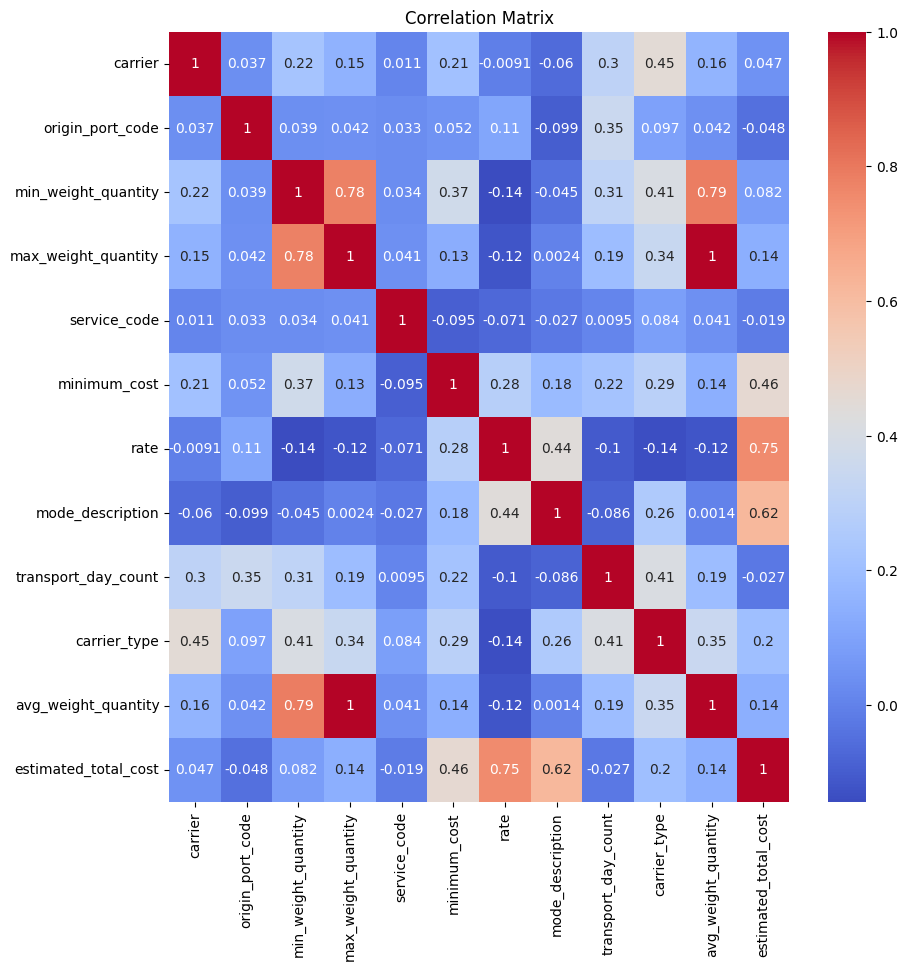

In [19]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 10))
fig = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

After analyzing the correlation matrix using a heatmap from Seaborn, we can observe that the features with the strongest relationships are:

	1.	Max Weight Quantity and Average Weight Quantity: These two features show the highest correlation.
	2.	Min Weight Quantity and Average Weight Quantity: This pair also exhibits a significant positive correlation.
	3.	Max Weight Quantity and Min Weight Quantity: These features are positively correlated as well.

Overall, it is clear that the weight-related features are closely correlated with each other. Additionally, it is worth noting that the Rate feature demonstrates a positive correlation with Estimated Total Cost.

### Checking For Outliers

<Figure size 1500x1500 with 0 Axes>

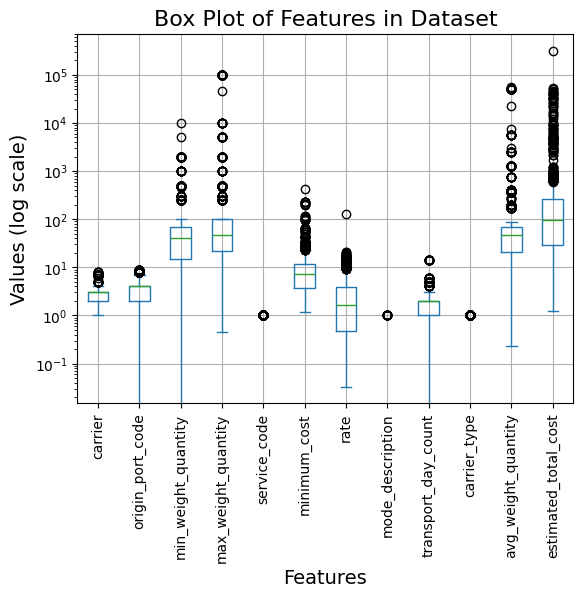

In [68]:
plt.figure(figsize=(15, 15))
data.plot(kind='box')
plt.title('Box Plot of Features in Dataset', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Values (log scale)', fontsize=14)
plt.yscale('log')  # Use logarithmic scale for better visualization
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [71]:
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)

IQR = q3 - q1

lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

mask = pd.Series([True] * data.shape[0])


for column in data.columns:
    if data[column].dtype in ['float64', 'int64']:
        mask &= (data[column] >= lower_bound[column]) & (data[column] <= upper_bound[column])


df_no_outliers = data[mask]

print("Filtered Data Shape:", df_no_outliers.shape)
print("Original Data Shape:", data.shape)

Filtered Data Shape: (803, 12)
Original Data Shape: (1539, 12)


### Visualizations

<Figure size 1500x1500 with 0 Axes>

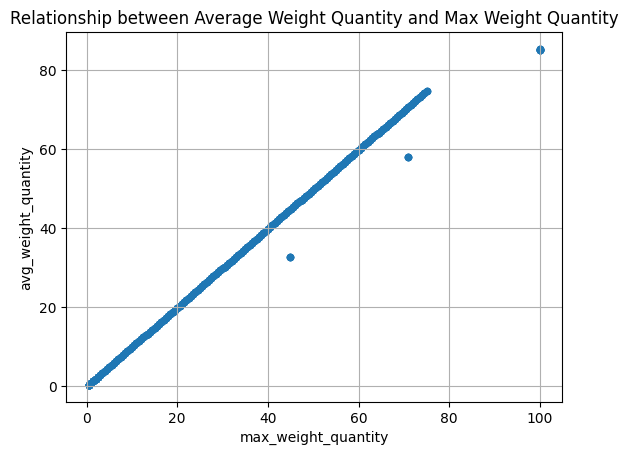

In [105]:
plt.figure(figsize=(15, 15))
df_no_outliers.plot(x="max_weight_quantity",
          y='avg_weight_quantity',
          kind='scatter')
plt.title("Relationship between Average Weight Quantity and Max Weight Quantity")
plt.grid(True)
plt.show()

By looking at the scatterplot, you can see that there is a strong correlation between max weight and average weight in the dataframe.

<Figure size 1500x1500 with 0 Axes>

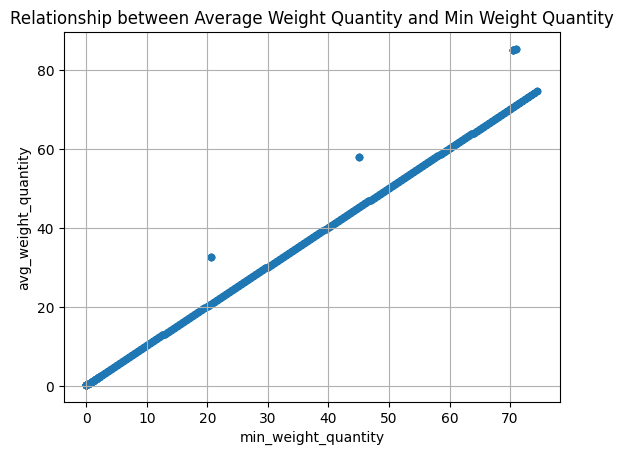

In [104]:
plt.figure(figsize=(15, 15))
df_no_outliers.plot(x="min_weight_quantity",
          y='avg_weight_quantity',
          kind='scatter')
plt.title("Relationship between Average Weight Quantity and Min Weight Quantity")
plt.grid(True)
plt.show()

Also, you can observe that there a strong positive correlation between min weight and average weight.

<Figure size 1500x1500 with 0 Axes>

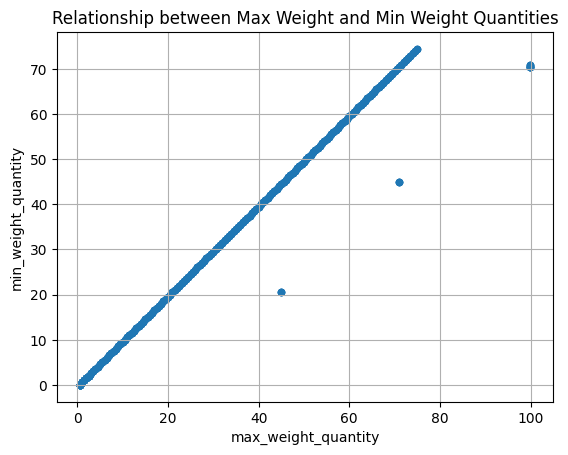

In [103]:
plt.figure(figsize=(15, 15))
df_no_outliers.plot(x="max_weight_quantity",
          y='min_weight_quantity',
          kind='scatter')
plt.title("Relationship between Max Weight and Min Weight Quantities")
plt.grid()
plt.show()

By comparing the max weight quantity and the min weight quantity features, you can observe that there is a strong positive correlation between there two features.

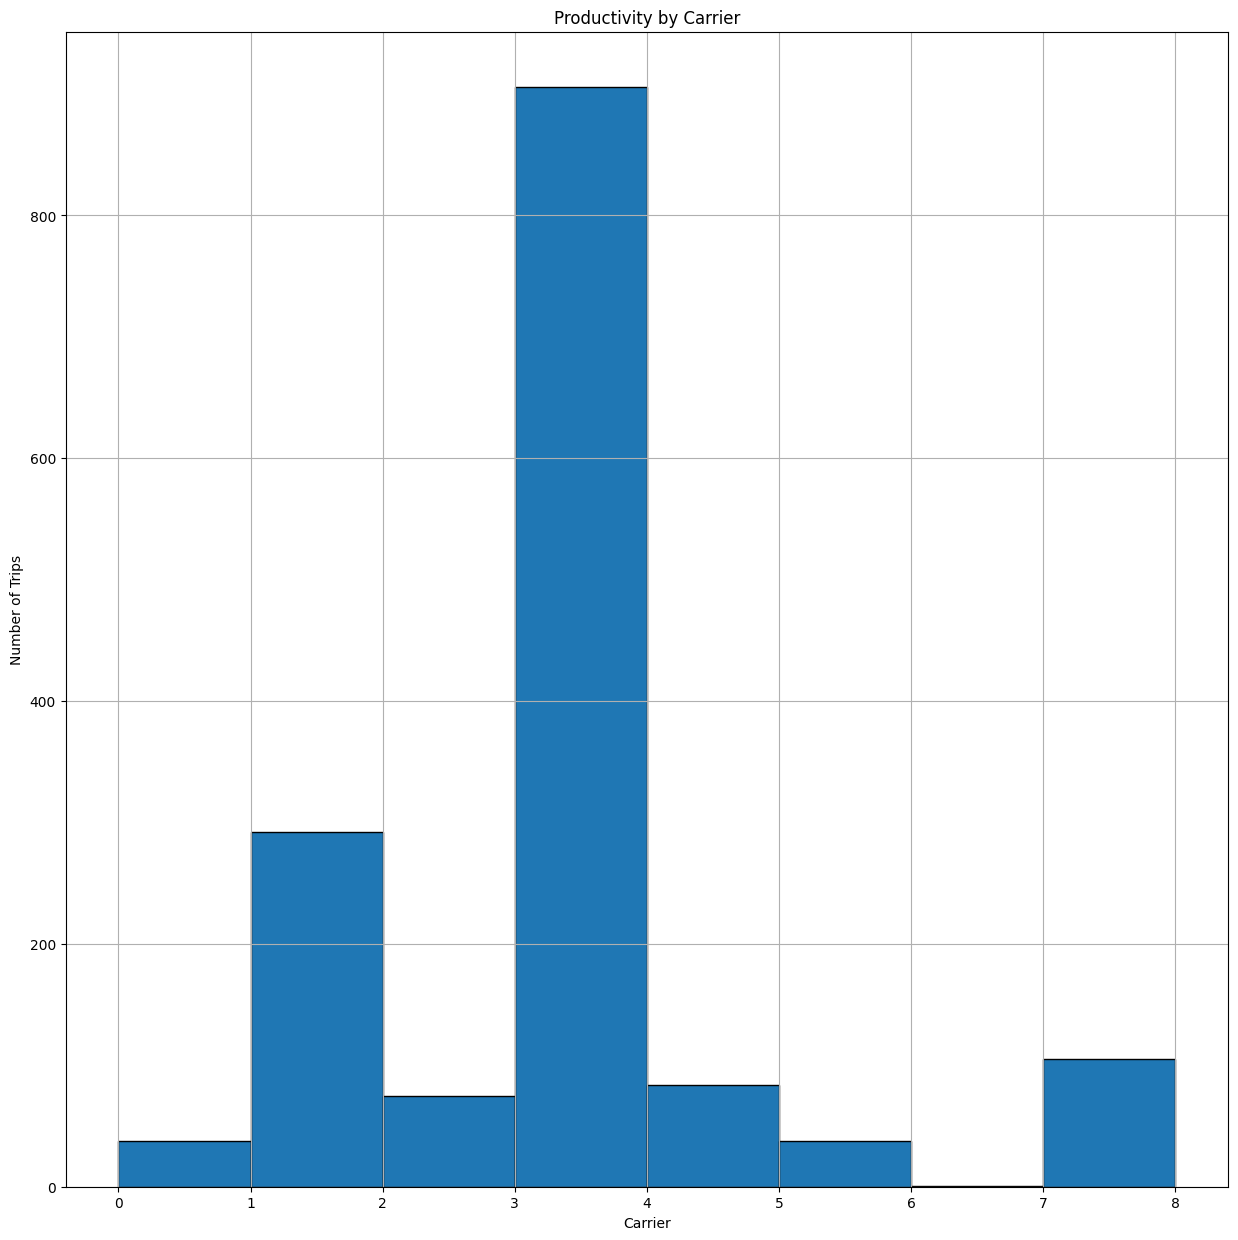

In [101]:
plt.figure(figsize=(15, 15))
data['carrier'].plot(
    kind='hist', edgecolor='black', bins=8
)
plt.xlabel("Carrier")
plt.ylabel("Number of Trips")
plt.title("Productivity by Carrier")
plt.grid()
plt.show()

As you can see by the Histogram, Carrier Number 3 is the busiest with the most amount of Trips.

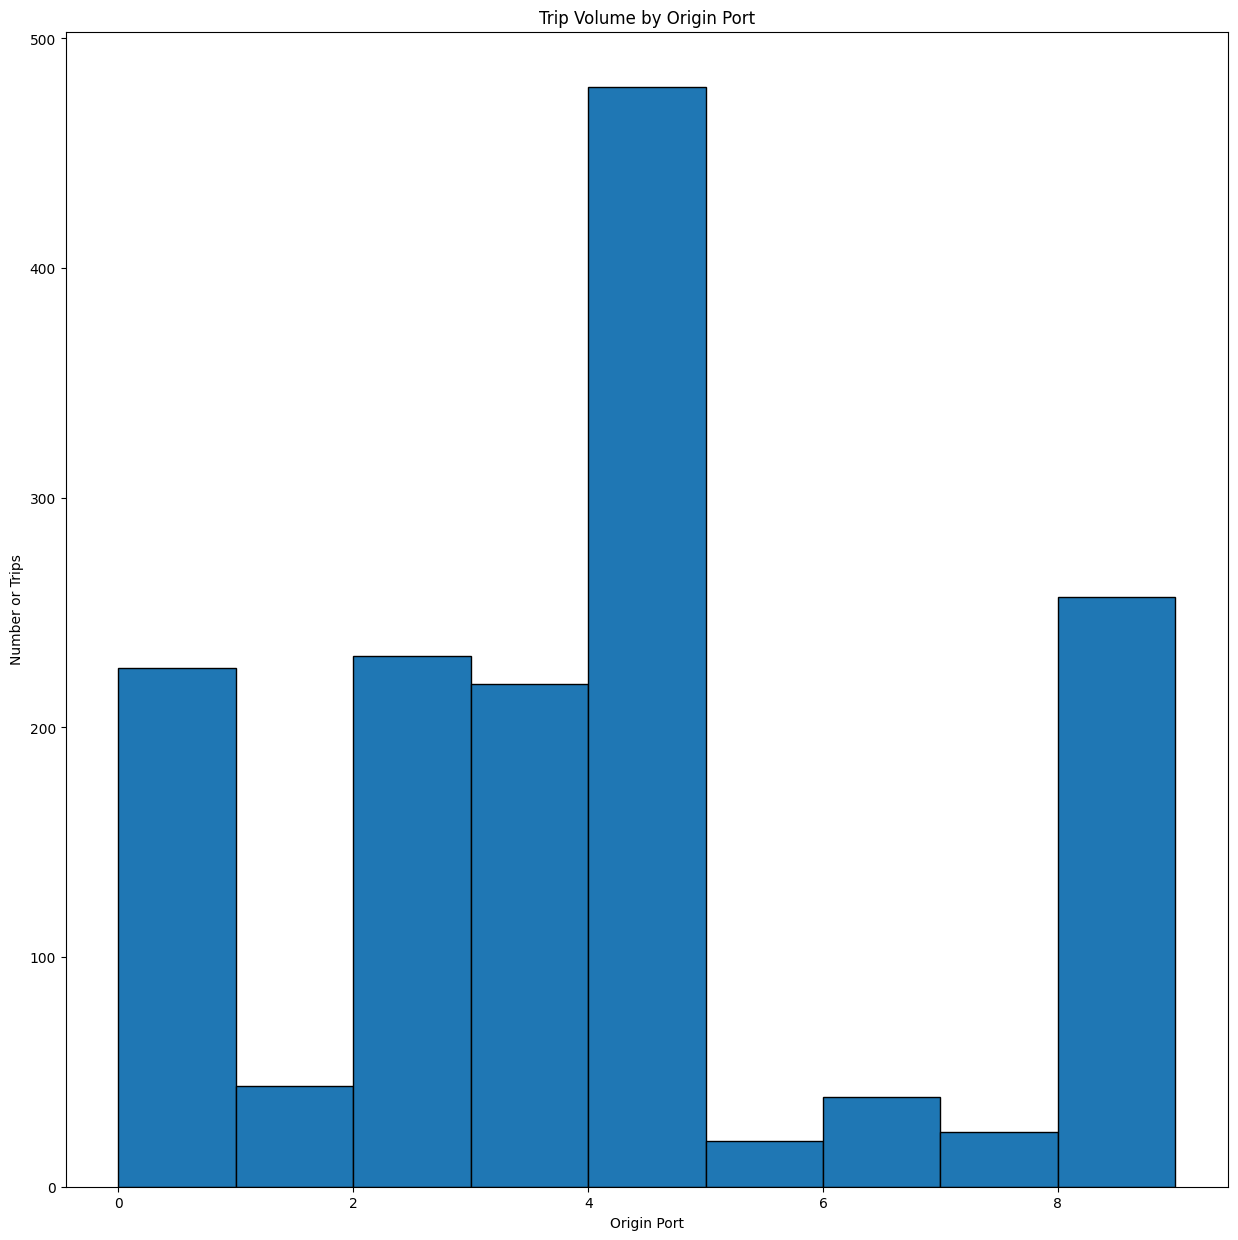

In [100]:

plt.figure(figsize=(15, 15))
data['origin_port_code'].plot(
    kind='hist', edgecolor='black', bins=9
)
plt.xlabel("Origin Port")
plt.ylabel("Number or Trips")
plt.title("Trip Volume by Origin Port")
plt.show()

By looking at the histogram, you can see that the busiest port is port number 4, it has twice as much volume as the rest of the ports.

## Exploratory Data Analysis Conclusion

Upon generating a correlation matrix, we identified that the ‘Destination Port Code’ column produced NaN values. A closer investigation revealed that this occurred due to zero variance, meaning all entries in this column were identical, providing no meaningful variance for analysis.

Next, through a heat map visualization of the correlation matrix, it became evident that ‘Max Weight Quantity’ and ‘Average Weight Quantity’ exhibited the highest positive correlation. Similarly, ‘Max Weight Quantity’ and ‘Min Weight Quantity’ were also strongly correlated. This suggests that weight-related features in the dataset are closely linked, highlighting the importance of these variables in our analysis.

Furthermore, a notable correlation was observed between the ‘Rate’ feature and ‘Estimated Cost,’ indicating a direct relationship that could be relevant for future modeling.

Before proceeding with machine learning, we performed thorough outlier detection and removal to ensure data quality. Additionally, scatter plots were utilized to further visualize and confirm the relationships between key variables. Histogram plots were also created to analyze the busiest ports and carriers, providing valuable insights into the dataset’s distribution

## Machine Learning

#### Splitting the Data

In [27]:
features = df_no_outliers.drop(['rate'], axis=1)
target = df_no_outliers['rate']

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=42)

#### Linear Regression

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
mse = mean_squared_error(y_pred, y_valid)
mae = mean_absolute_error(y_pred, y_valid)
r2_score_linear = r2_score(y_pred, y_valid)
print(f"MSE Linear Regression: {mse:.2f}")
print(f"MAE Linear Regression: {mae:.2f}")
print(f"R2 Score Linear Regression: {r2_score_linear:.2f}")

MSE Linear Regression: 0.20
MAE Linear Regression: 0.35
R2 Score Linear Regression: 0.93


### Decision Tree

In [30]:
model_decision = DecisionTreeRegressor()
model_decision.fit(X_train, y_train)
y_pred_decision = model_decision.predict(X_valid)
mse_decision = mean_squared_error(y_pred_decision, y_valid)
mae_decision = mean_absolute_error(y_pred_decision, y_valid)
r2_score_decision = r2_score(y_valid, y_pred_decision)
print(f"MSE DEcision Tree {mse_decision:.2f}")
print(f"MAE Decision Tree {mae_decision:.2f}")
print(f"R2 Score {r2_score_decision:.2f}")

MSE DEcision Tree 0.04
MAE Decision Tree 0.10
R2 Score 0.99


### Random Forest Regressor

In [81]:
model_random = RandomForestRegressor(max_depth= 10, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state=12345)
model_random.fit(X_train, y_train)
y_pred_random = model_random.predict(X_valid)
mse_random = mean_squared_error(y_valid, y_pred_random)
mae_random = mean_absolute_error(y_valid, y_pred_random)
r2_random = r2_score(y_valid, y_pred_random)
print(f"MSE Random Forest Regressor {mse_random:.2f}")
print(f"MAE Random Forest Regressor {mae_random:.2f}")
print(f"R2 Score Random Forest Regressor {r2_random:.2f}")

MSE Random Forest Regressor 0.02
MAE Random Forest Regressor 0.09
R2 Score Random Forest Regressor 0.99


### Cross Validation on Random Forest Regressor

In [32]:
y_pred_train = model_random.predict(X_train)
mse_train = mean_squared_error(y_pred_train, y_train)

scores = cross_val_score(model_random, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores

print(f"MSE on Training set {mse_train:.2f}")
print(f"MSE Scores for each fold {mse_scores}")
print(f"MSE Mean {mse_scores.mean():.2f}")
print(f"Standard Deviation of MSE {mse_scores.std():.2f}")



MSE on Training set 0.00
MSE Scores for each fold [0.03739018 0.01728856 0.05334494 0.05178872 0.04509681]
MSE Mean 0.04
Standard Deviation of MSE 0.01


### Evaluating Model on Validation Set Random Forest Regressor

In [33]:

y_pred_valid = model_random.predict(X_valid)
mse_valid = mean_squared_error(y_valid, y_pred_valid)
mae_valid = mean_absolute_error(y_valid, y_pred_valid)
r2_valid = r2_score(y_valid, y_pred_valid)
print(f"MSE on Validation Set: {mse_valid:.2f}")
print(f"MAE on Validation Set: {mae_valid:.2f}")
print(f"R2 Score on Validation Set: {r2_valid:.2f}")

MSE on Validation Set: 0.02
MAE on Validation Set: 0.09
R2 Score on Validation Set: 0.99


1.Training MSE (0.00):  

•The training MSE is exceptionally low, indicating that the model fits the training data perfectly. This can be a sign of overfitting, but it depends on how it performs on unseen data.

2.Validation MSE (0.02):  

•The validation MSE is slightly higher than the training MSE, which is typical and expected. It indicates that while the model is performing well on the validation set, it is not perfect. The small difference suggests that the model has learned useful patterns without capturing too much noise from the training data.

3.Cross-Validation MSE Mean (~0.04):  

•The mean MSE from cross-validation (approximately 0.04) serves as a benchmark for the models performance. Since the validation MSE (0.02) is lower than this average, it indicates that the model is performing better on the validation set than on average across the different folds of cross-validation.

Conclusion on Overfitting:

•Not Overfitting:
•The results suggest that the model is likely not overfitting since the validation MSE is reasonably low and below the mean MSE from cross-validation. This indicates that the model is generalizing well to unseen data rather than merely memorizing the training data.

### Evaluating the model on the Test Set

In [88]:
y_pred_test = model_random.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"MSE Random Forest Test Set: {mse_test:.2f}")
print(f"MAE Random Forest Test Set: {mae_test:.2f}")
print(f"R2 Score Random Forest Test Set: {r2_test:.2f}")

MSE Random Forest Test Set: 0.02
MAE Random Forest Test Set: 0.08
R2 Score Random Forest Test Set: 1.00


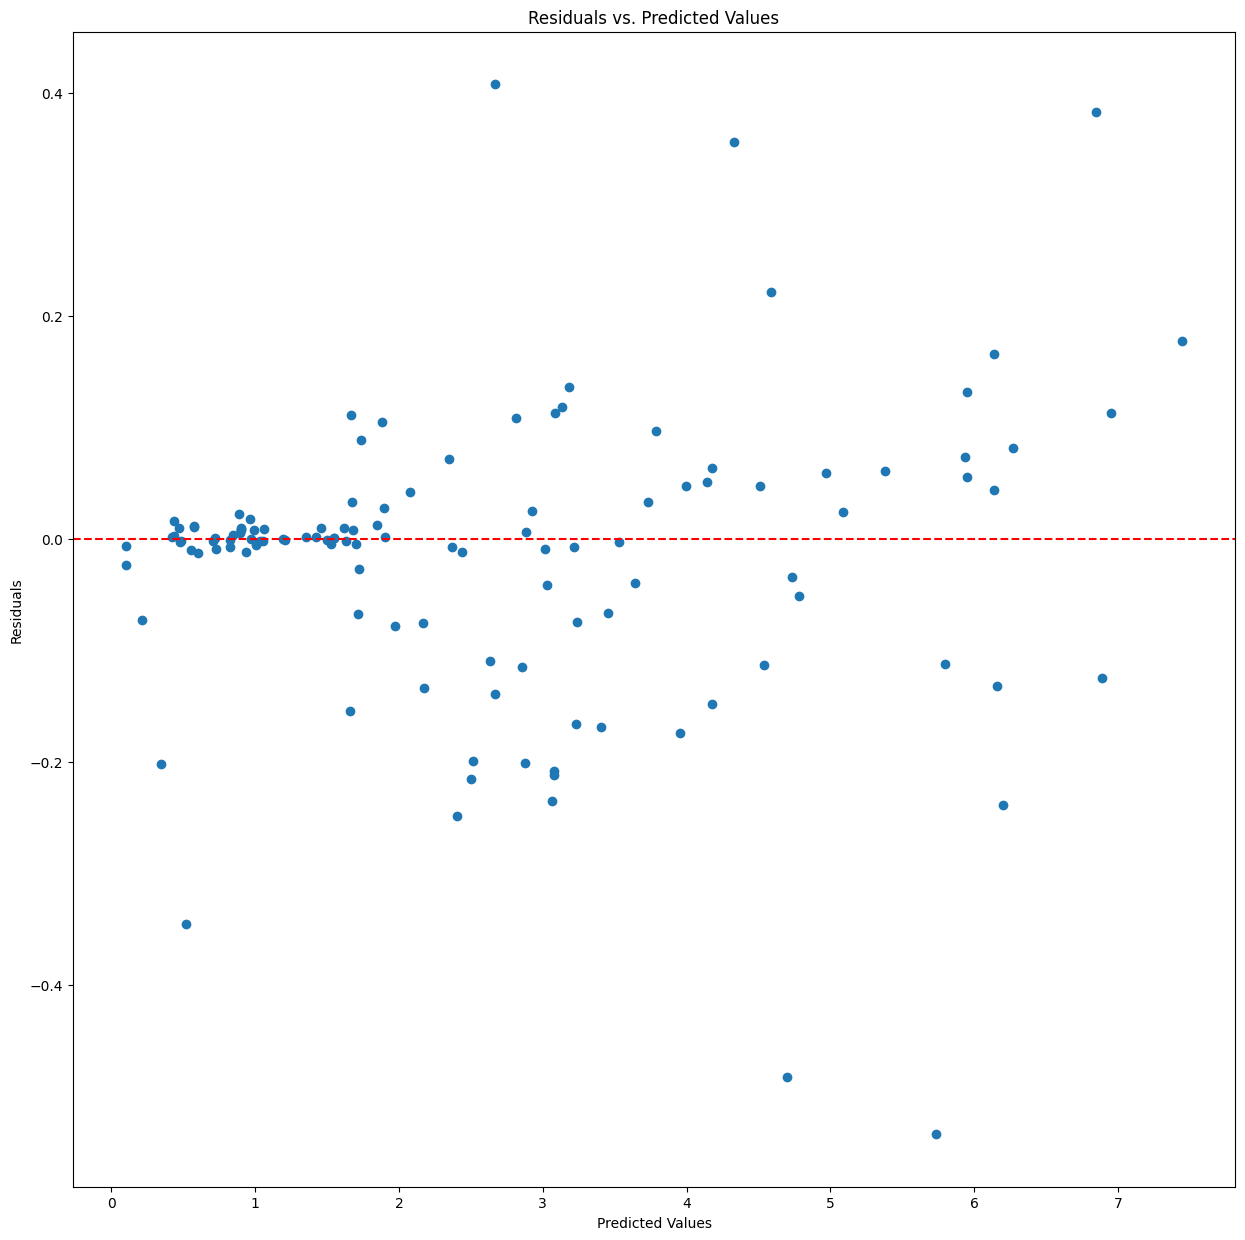

In [99]:
residuals = y_test - y_pred_test
plt.figure(figsize=(15, 15))
plt.scatter(y_pred_test, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

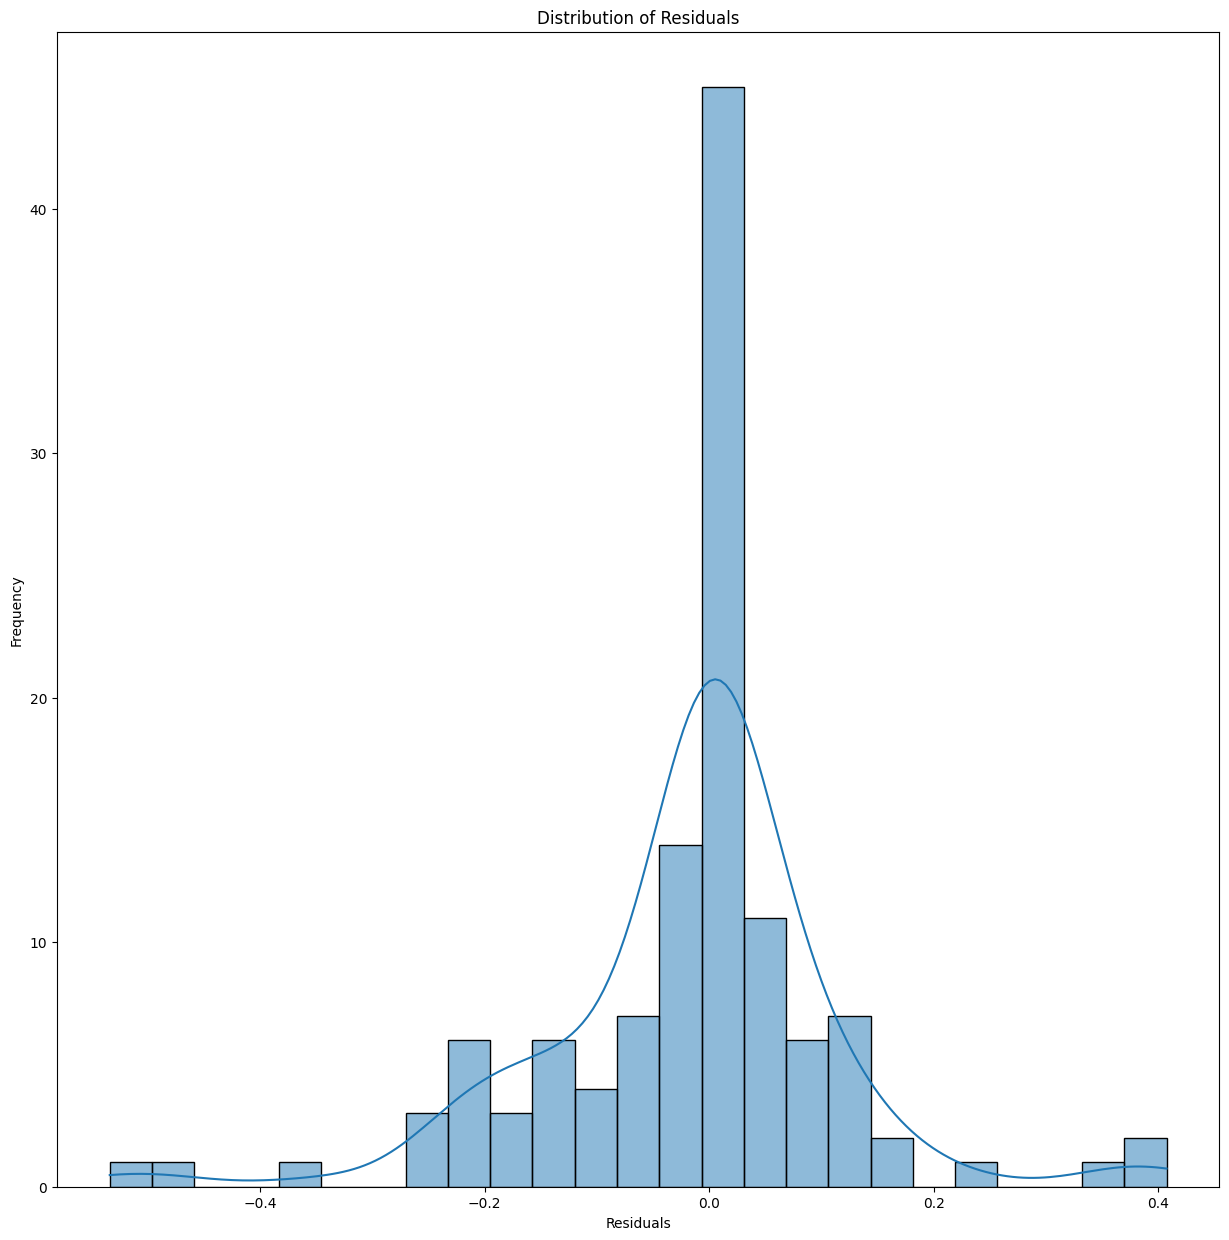

In [98]:

plt.figure(figsize=(15, 15))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

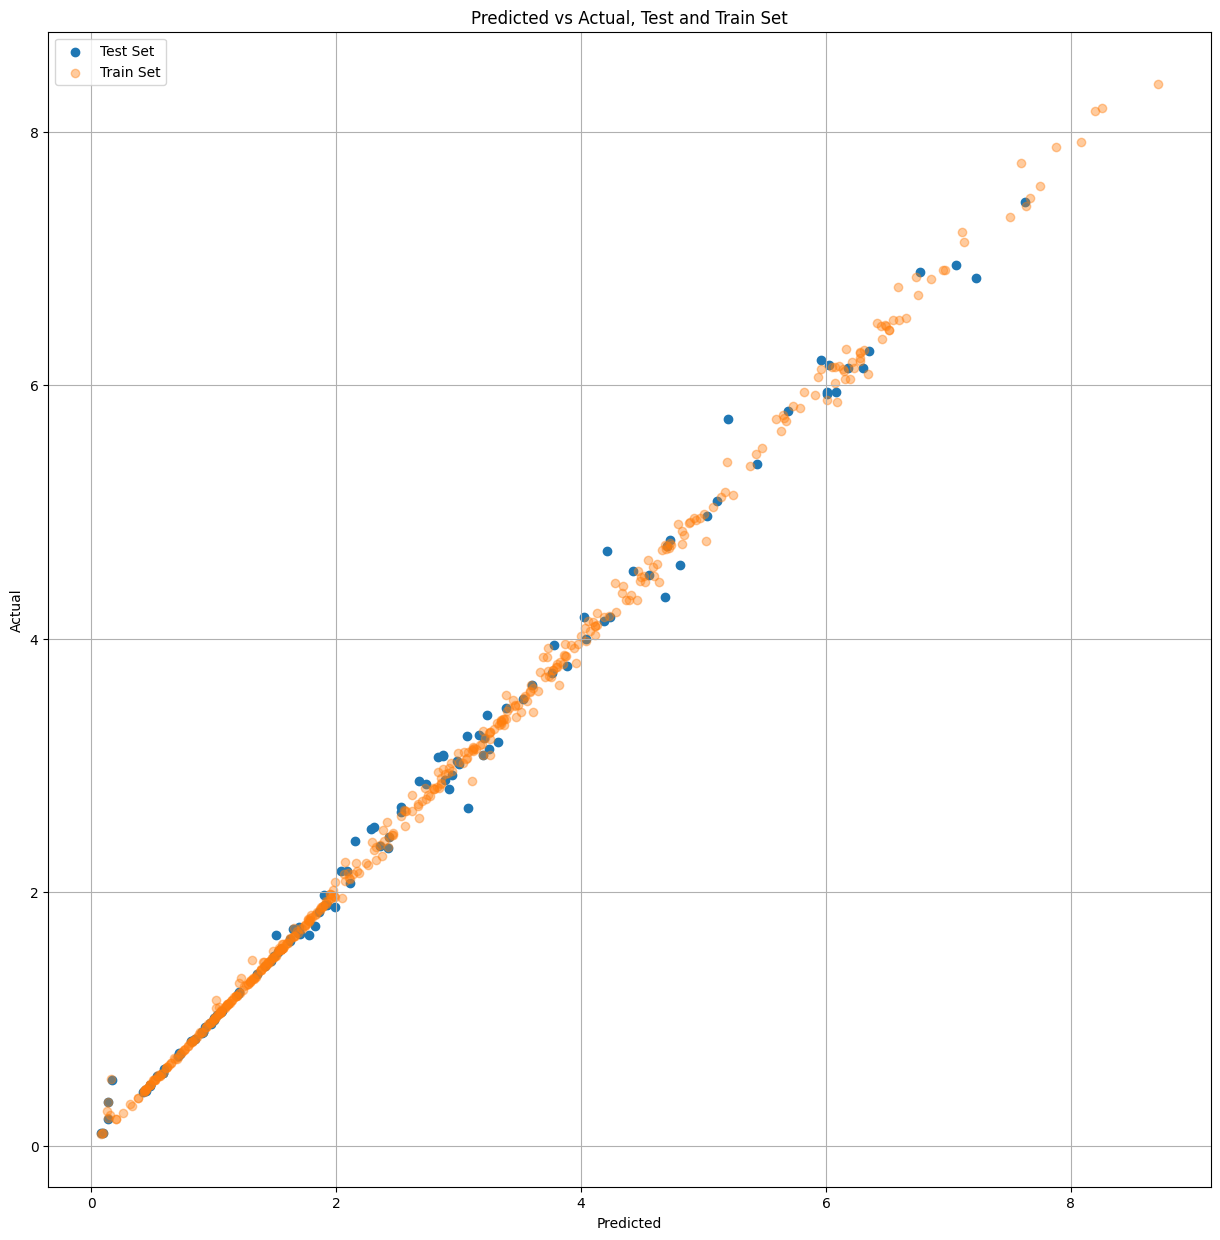

In [106]:

plt.figure(figsize=(15, 15))
plt.scatter(
    y_test,
    y_pred_test,
    label="Test Set"
)
plt.scatter(
    y_train,
    y_pred_train,
    label="Train Set",
    alpha=.4
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicted vs Actual, Test and Train Set")
plt.grid()
plt.legend()
plt.show()

## Conclusion

In conclusion, the Random Forest Regression model performed exceptionally well on both the training and test sets, as reflected by its high R2 score of 1.00 and low error metrics, such as a mean squared error (MSE) of 0.02 on the test set. Cross-validation confirmed the model’s ability to generalize effectively, with an MSE mean of 0.04 and a standard deviation of 0.01. To further validate the model, we created residual plots and scatterplots comparing the predicted and actual values for both the test set (y_test vs. y_pred_test) and the training set (y_train vs. y_pred_train), providing clear visual evidence of the model’s accuracy and robustness without overfitting.

## Saving the Model

In [108]:
joblib.dump(model_random, 'rate_prediction.pkl')

['rate_prediction.pkl']